In [18]:
import numpy as np
import pandas as pd
import scanpy as sc
from sklearn.decomposition import TruncatedSVD
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from umap.umap_ import UMAP
import umap
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
import os
import scanpy as sc
from sklearn.decomposition import PCA

import tensorflow as tf
from tensorflow.keras import layers, models, backend as K
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import mse


In [ ]:
with open("top_1000_genes.txt", "r") as f:
    top_genes = [line.strip() for line in f.readlines()]

adata = sc.read_h5ad("mouse_diabetes.h5ad", backed='r')

genes_available = [g for g in top_genes if g in adata.var_names]
print(f"Using {len(genes_available)} of {len(top_genes)} requested genes.")

obs_df = adata.obs.copy()
obs_df = obs_df[~obs_df['cell_type'].isin(['unknown', 'cell', 'endothelial cell', 'hematopoietic cell', 'pancreatic stellate cell', 'pandreatic ductal cell'])]

obs_df['strata'] = obs_df['cell_type'].astype(str) + "_" + obs_df['disease'].astype(str)

total_sample_size = 20000
np.random.seed(42)

strata_counts = obs_df['strata'].value_counts()
strata_sample_sizes = (strata_counts / strata_counts.sum() * total_sample_size).round().astype(int)

sampled_indices = []
for strata_value, sample_size in strata_sample_sizes.items():
    strata_indices = obs_df[obs_df['strata'] == strata_value].index
    if len(strata_indices) < sample_size:
        sample_size = len(strata_indices)
    sampled_indices.extend(np.random.choice(strata_indices, sample_size, replace=False))

adata_sampled = adata[sampled_indices, genes_available].to_memory()

sc.pp.log1p(adata_sampled)

# Now adata_sampled contains only sampled cells and only the most important genes

Using 1000 of 1000 requested genes.


In [18]:
adata = sc.read_h5ad("mouse_diabetes.h5ad", backed='r')

# Access obs (cell metadata) - this is fully loaded into memory
obs_df = adata.obs.copy()
obs_df = obs_df[~obs_df['cell_type'].isin(['unknown', 'cell'])]

# Determine total samples
total_sample_size = 20000
np.random.seed(42)


# Optional: check your metadata structure
# print(obs_df['cell_type'].value_counts())
# print(obs_df['disease_type'].value_counts())

# Create a combined stratification column if you want to conserve both cell type and disease type
obs_df['strata'] = obs_df['cell_type'].astype(str) + "_" + obs_df['disease'].astype(str)

# Sample size per strata proportional to their representation
strata_counts = obs_df['strata'].value_counts()
strata_sample_sizes = (strata_counts / strata_counts.sum() * total_sample_size).round().astype(int)

# Perform sampling per strata
sampled_indices = []
for strata_value, sample_size in strata_sample_sizes.items():
    strata_indices = obs_df[obs_df['strata'] == strata_value].index
    if len(strata_indices) < sample_size:
        sample_size = len(strata_indices)  # avoid over-sampling
    sampled_indices.extend(np.random.choice(strata_indices, sample_size, replace=False))

# Now, create a new AnnData with only these samples
adata_sampled = adata[sampled_indices].to_memory()

sc.pp.log1p(adata_sampled)


In [33]:
disease_types = adata_sampled.obs['disease'].unique()

# Create a dictionary to hold disease-specific arrays
disease_arrays = {}

for disease in disease_types:
    subset = adata_sampled[adata_sampled.obs['disease'] == disease]
    
    # Convert X to dense array if needed
    X_array = subset.X.toarray() if not isinstance(subset.X, np.ndarray) else subset.X
    
    disease_arrays[disease] = X_array
    
    print(f"{disease}: shape {X_array.shape}")

combined_data_normal = disease_arrays['normal']
combined_data_endocrine = disease_arrays['endocrine pancreas disorder']
combined_data_type1 = disease_arrays['type 1 diabetes mellitus']
combined_data_type2 = disease_arrays['type 2 diabetes mellitus']

normal: shape (8796, 1000)
type 2 diabetes mellitus: shape (7327, 1000)
endocrine pancreas disorder: shape (1844, 1000)
type 1 diabetes mellitus: shape (2032, 1000)


In [34]:
X = adata_sampled.X.toarray()

#Using a SVD

svd = TruncatedSVD(n_components=50, random_state=42)
combined_data_normal_reduced = svd.fit_transform(combined_data_normal)
adata_reduced = svd.transform(X)

scaler = MaxAbsScaler()
combined_data_normal_scaled = scaler.fit_transform(combined_data_normal_reduced)
adata_scaled = scaler.transform(adata_reduced)

# Actually using PCA)

#pca = PCA(n_components=50, random_state=42)
#combined_data_normal_reduced = pca.fit_transform(combined_data_normal)
#adata_reduced = pca.transform(X)

#scaler = MaxAbsScaler()
#combined_data_normal_scaled = scaler.fit_transform(combined_data_normal_reduced)
#adata_scaled = scaler.transform(adata_reduced)

c:\Users\jakob\AppData\Local\Programs\Python\Python311\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


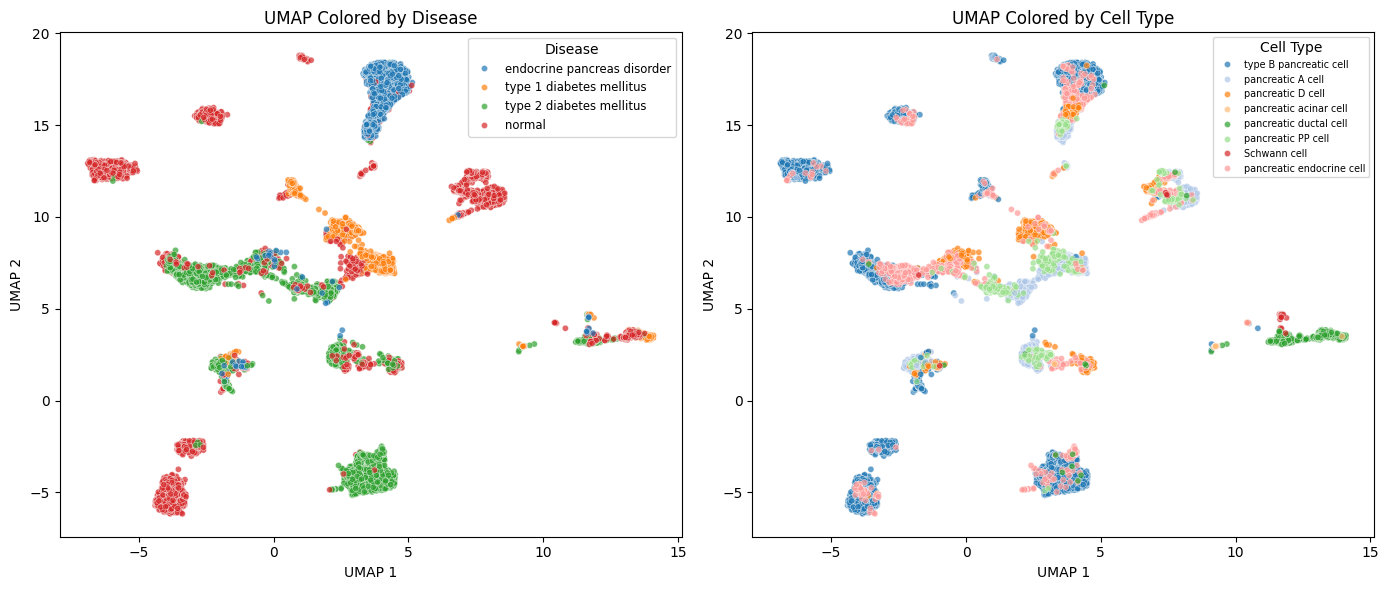

In [35]:
# Get labels
disease_labels = adata_sampled.obs['disease'].values
cell_type_labels = adata_sampled.obs['cell_type'].values

# Run UMAP on SVD-reduced data
umap_model = umap.UMAP(random_state=42)
umap_embedding = umap_model.fit_transform(adata_scaled)

# Create figure with 1x2 subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6), dpi=100)

# First subplot: colored by disease
sns.scatterplot(
    x=umap_embedding[:, 0], y=umap_embedding[:, 1],
    hue=disease_labels,
    palette='tab10',
    alpha=0.7, s=20,
    ax=axes[0], legend='full'
)
axes[0].set_title("UMAP Colored by Disease")
axes[0].set_xlabel("UMAP 1")
axes[0].set_ylabel("UMAP 2")
axes[0].legend(loc='best', fontsize='small', title='Disease')

# Second subplot: colored by cell type
sns.scatterplot(
    x=umap_embedding[:, 0], y=umap_embedding[:, 1],
    hue=cell_type_labels,
    palette='tab20',
    alpha=0.7, s=20,
    ax=axes[1], legend='full'
)
axes[1].set_title("UMAP Colored by Cell Type")
axes[1].set_xlabel("UMAP 1")
axes[1].set_ylabel("UMAP 2")
axes[1].legend(loc='best', fontsize='x-small', title='Cell Type')

plt.tight_layout()
plt.show()

In [42]:
data_normal_scaled_train,  data_normal_scaled_val = train_test_split(combined_data_normal_scaled, test_size=0.2, random_state=42)

early_stopping = EarlyStopping(
    monitor='val_loss',   # monitor validation loss
    patience=5,           # number of epochs with no improvement after which training will stop
    restore_best_weights=True,  # restore model weights from the epoch with the best val_loss
    verbose=1
)


# Set dimensions
input_dim = data_normal_scaled_train.shape[1]
encoding_dim = 10  # or any dimension you prefer

# Define encoder
input_layer = layers.Input(shape=(input_dim,))
encoded = layers.Dense(24, activation='relu')(input_layer)
encoded = layers.Dense(encoding_dim, activation='relu')(encoded)

# Define decoder
decoded = layers.Dense(24, activation='relu')(encoded)
decoded = layers.Dense(input_dim, activation='relu')(decoded)

# Build and compile the model
autoencoder = models.Model(inputs=input_layer, outputs=decoded)
autoencoder.compile(optimizer='adam', loss='mae')

# Train the autoencoder
history = autoencoder.fit(
    data_normal_scaled_train, data_normal_scaled_train,
    epochs=40,
    batch_size=16,
    shuffle=True,
    validation_data=(data_normal_scaled_val, data_normal_scaled_val),
    callbacks=[early_stopping],
    verbose=1
)

# You can also extract the encoder part
encoder = models.Model(inputs=input_layer, outputs=encoded)


Epoch 1/40
440/440 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1652 - val_loss: 0.1527
Epoch 2/40
440/440 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1506 - val_loss: 0.1485
Epoch 3/40
440/440 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.1471 - val_loss: 0.1457
Epoch 4/40
440/440 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1442 - val_loss: 0.1433
Epoch 5/40
440/440 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.1422 - val_loss: 0.1421
Epoch 6/40
440/440 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.1406 - val_loss: 0.1417
Epoch 7/40
440/440 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.1410 - val_loss: 0.1414
Epoch 8/40
440/440 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.1405 - val_loss: 0.1412
Epoch 9/40
440/440 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1408 - val_loss: 0.1412
Epoch 10/40
440/440 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1397 - val_loss: 0.1410
Epoch 11/40
440/440 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1404 - val_loss: 0.1407
Epoch 12/40
440/440 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 908us/step


c:\Users\jakob\AppData\Local\Programs\Python\Python311\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


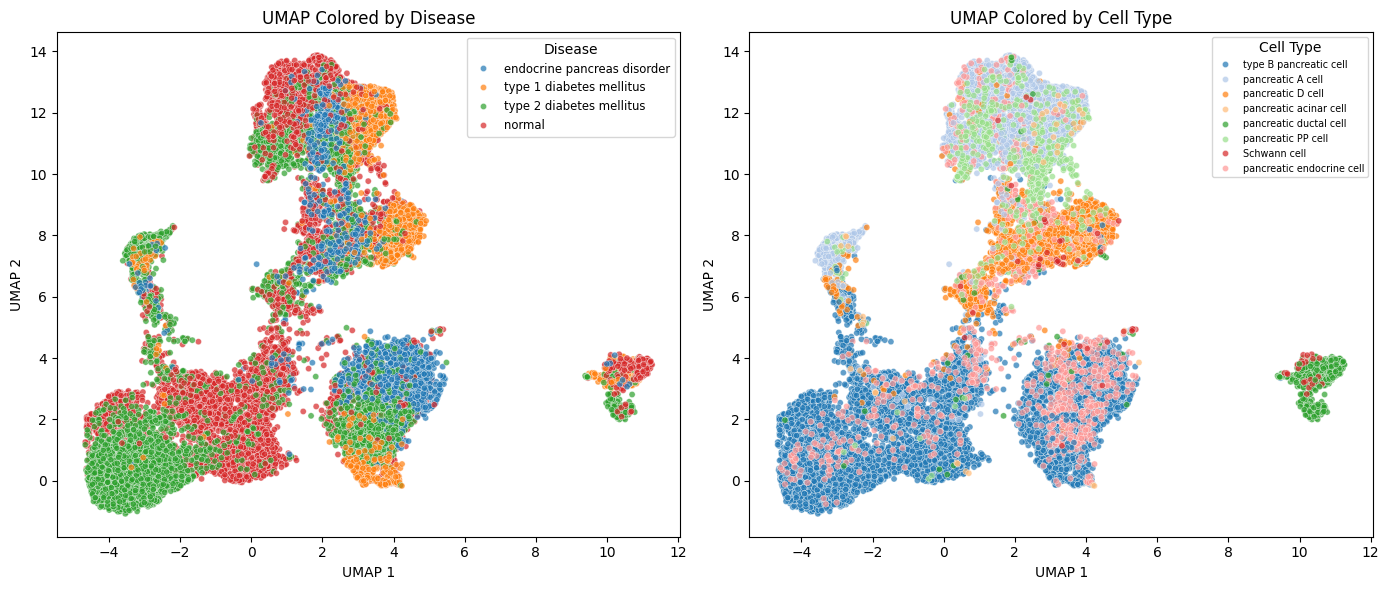

In [43]:
adata_latent = encoder.predict(adata_scaled)

umap_model = umap.UMAP(random_state=42)
umap_embedding = umap_model.fit_transform(adata_latent)

# Create figure with 1x2 subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6), dpi=100)

# First subplot: colored by disease
sns.scatterplot(
    x=umap_embedding[:, 0], y=umap_embedding[:, 1],
    hue=disease_labels,
    palette='tab10',
    alpha=0.7, s=20,
    ax=axes[0], legend='full'
)
axes[0].set_title("UMAP Colored by Disease")
axes[0].set_xlabel("UMAP 1")
axes[0].set_ylabel("UMAP 2")
axes[0].legend(loc='best', fontsize='small', title='Disease')

# Second subplot: colored by cell type
sns.scatterplot(
    x=umap_embedding[:, 0], y=umap_embedding[:, 1],
    hue=cell_type_labels,
    palette='tab20',
    alpha=0.7, s=20,
    ax=axes[1], legend='full'
)
axes[1].set_title("UMAP Colored by Cell Type")
axes[1].set_xlabel("UMAP 1")
axes[1].set_ylabel("UMAP 2")
axes[1].legend(loc='best', fontsize='x-small', title='Cell Type')

plt.tight_layout()
plt.show()
